In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import matplotlib.pyplot as plt

from scipy.fft import fft, fftfreq
import scipy


# signals -> a single data point
def fourier_transform(signals, sampling_rate):
    for signal in signals:
        fft_result = np.abs(scipy.fft.fft(signal))  # Get rid of imaginary values 
        frequencies = fftfreq(len(signal), 1 / sampling_rate)  # Frequency bins
        fft_magnitudes = fft_result[:len(fft_result)//2] # Positive magnitudes
        frequencies = frequencies[:len(frequencies)//2] # Positive frequencies
        
    return fft_magnitudes, frequencies

def plot_fourier_transforms(signals, sampling_rate): # Defined for each channel in a single data point. 
    for i, signal in enumerate(signals):
        # Perform FFT
        fft_magnitudes, frequencies = fourier_transform([signal], sampling_rate)

        # Plot the positive frequency spectrum
        plt.figure(figsize=(10, 5))
        plt.plot(frequencies, fft_magnitudes)
        plt.xlim(0, sampling_rate // 2)
        plt.title(f'Fourier Transform of Signal {i + 1}')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Amplitude')
        plt.grid(True)
        plt.show()



from scipy.signal import find_peaks
def extract_channel_features(i, signal, sampling_rate):
    """Extract specified features for a single channel."""
    # FFT computation
    fft_result, frequencies = fourier_transform([signal], sampling_rate)

    # Keep only positive frequencies
    positive_frequencies = frequencies > 0
    fft_result = fft_result[positive_frequencies]
    frequencies = frequencies[positive_frequencies]

    # Dominant frequency and amplitude
    dominant_idx = np.argmax(fft_result)
    dominant_frequency = frequencies[dominant_idx]
    dominant_amplitude = fft_result[dominant_idx]

    # Total power
    total_power = np.sum(fft_result**2)/len(fft_result)

    # Spectral centroid
    spectral_centroid = np.sum(frequencies * fft_result) / np.sum(fft_result)

    # Spectral bandwidth
    spectral_bandwidth = np.sqrt(np.sum(((frequencies - spectral_centroid)**2) * fft_result) / np.sum(fft_result))

    # Shannon entropy
    spectral_prob = fft_result / np.sum(fft_result)
    spectral_entropy = -np.sum(spectral_prob * np.log2(spectral_prob + 1e-12))  # Adding a small value for numerical stability

    # Frequency variance
    frequency_variance = np.var(fft_result)

    # Zero-crossing rate (ZCR) of the original signal
    zcr = np.sum(np.sign(np.diff(signal)) != 0)/len(signal)

    return {
        "Channel":i,
        "Dominant_Frequency": dominant_frequency,
        "Dominant_Amplitude": dominant_amplitude,
        "Total_Power": total_power,
        "Spectral_Centroid": spectral_centroid,
        "Spectral_Bandwidth": spectral_bandwidth,
        "Spectral_Entropy": spectral_entropy,
        "Frequency_Variance": frequency_variance,
        "Zero_Crossing_Rate": zcr
    }

def signal_features(signals, sampling_rate):
    features = []
    for i in range(len(signals)):
        signal = signals[i]
        features.append(extract_channel_features(i+1, signal, sampling_rate))
    return pd.DataFrame(features)

def flatten_features(features_df):
    # Create an empty dictionary to store flattened features
    flattened_features = {}
    # Iterate through each column (feature) in the DataFrame
    for column in features_df.columns:
        if column != "Channel":  # Skip the Channel column as it's used for indexing
            for idx, value in enumerate(features_df[column]):
                # Create a unique key for each feature-channel combination
                key = f"{column}_Ch{idx + 1}"
                flattened_features[key] = value
    
    return pd.DataFrame([flattened_features])



In [4]:
import os
import numpy as np
import pandas as pd

def load_to_df(folder_path, label):

    data = []
    file_names = [] 

    for file_name in os.listdir(folder_path):
        if file_name.endswith('.npy'): 
            file_path = os.path.join(folder_path, file_name)
            array = np.load(file_path)
            data.append(array)
            file_names.append(file_name)

    df = pd.DataFrame({'ArrayData': data, 'Label': label})
    return df


In [5]:
# Normal -> 0, Complex Partial Seizures -> 1, Electrographic Seizures -> 2, Video detected seizures -> 3
# Training Dataset
cps_df = load_to_df("/kaggle/input/eeg-data/EEG_Data/train_data/Complex_Partial_Seizures",1)
print(cps_df.shape)
es_df = load_to_df("/kaggle/input/eeg-data/EEG_Data/train_data/Electrographic_Seizures",2)
print(es_df.shape)
normal_df = load_to_df("/kaggle/input/eeg-data/EEG_Data/train_data/Normal",0)
print(normal_df.shape)
vds_df = load_to_df("/kaggle/input/eeg-data/EEG_Data/train_data/Video_detected_Seizures_with_no_visual_change_over_EEG",3)
print(vds_df.shape)
train_data = pd.concat([cps_df,es_df,normal_df,vds_df],ignore_index=True)
train_data =  train_data.sample(frac=1, random_state=42).reset_index(drop=True)

X_train = np.stack(train_data['ArrayData'].to_numpy())
X_train = X_train / np.max(X_train)
X_train = np.transpose(X_train, (0, 2, 1))

(2196, 2)
(545, 2)
(2783, 2)
(84, 2)


In [6]:
from tensorflow.keras.utils import to_categorical
labels = train_data['Label'].to_numpy()
y_train = to_categorical(labels, num_classes=4)

In [7]:
# Validation Dataset
cps_val_df = load_to_df("/kaggle/input/eeg-data/EEG_Data/validation_data/Complex_Partial_Seizures",1)
es_val_df = load_to_df("/kaggle/input/eeg-data/EEG_Data/validation_data/Electrographic_Seizures",2)

normal_val_df = load_to_df("/kaggle/input/eeg-data/EEG_Data/validation_data/Normal",0)

vds_val_df = load_to_df("/kaggle/input/eeg-data/EEG_Data/validation_data/Video_detected_Seizures_with_no_visual_change_over_EEG",3)

val_data = pd.concat([cps_val_df,es_val_df,normal_val_df,vds_df],ignore_index=True)
val_data =  val_data.sample(frac=1, random_state=42).reset_index(drop=True)

X_val = np.stack(val_data['ArrayData'].to_numpy())
X_val = np.transpose(X_val/np.max(X_val), (0,2,1)) # (n_samples, time, n_channels)
print(X_val.shape)
Y_val = to_categorical(val_data['Label'].to_numpy(), num_classes = 4)

(1466, 500, 19)


In [8]:
# Test Dataset
test_data = []
test_folder_path = "/kaggle/input/eeg-data/EEG_Data/test_data"
for filename in os.listdir(test_folder_path):
    if filename.endswith(".npy"):
        file_path = os.path.join(test_folder_path, filename)
        array = np.load(file_path)
        test_data.append(array)
test_data = np.array(test_data)

In [9]:
test_data = np.transpose(test_data,[0,2,1])
print(test_data.shape) # (n_samples,time,n_channels)

(779, 500, 19)


MODEL

In [34]:
# Building the Model

from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dropout, Flatten, Dense, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# First convolutional block
x = Conv1D(filters=32, kernel_size=3)(input_layer)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.2)(x)

# Second convolutional block
x = Conv1D(filters=64, kernel_size=3)(x)
x = Activation('relu')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.3)(x)

# Third convolutional block
x = Conv1D(filters=128, kernel_size=3)(x)
x = Activation('relu')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.3)(x)

# Fourth convolutional block
x = Conv1D(filters=256, kernel_size=3)(x)
x = Activation('relu')(x)
x = MaxPooling1D(pool_size=2)(x)

# Flatten
x = Flatten()(x)

# Fully connected layers
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)

# Output layer for classification
output_layer = Dense(4, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 500, 19)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_20 (Conv1D)                   │ (None, 498, 32)             │           1,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 498, 32)             │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_20 (Activation)           │ (None, 498, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_20 (MaxPooling1D)      │ (None, 249, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 249, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_21 (Conv1D)                   │ (None, 247, 64)             │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_21 (Activation)           │ (None, 247, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_21 (MaxPooling1D)      │ (None, 123, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 123, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_22 (Conv1D)                   │ (None, 121, 128)            │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_22 (Activation)           │ (None, 121, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_22 (MaxPooling1D)      │ (None, 60, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 60, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_23 (Conv1D)                   │ (None, 58, 256)             │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_23 (Activation)           │ (None, 58, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_23 (MaxPooling1D)      │ (None, 29, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 7424)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 256)                 │       1,900,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │          32,8

 Total params: 2,065,668 (7.88 MB)

 Trainable params: 2,065,604 (7.88 MB)

 Non-trainable params: 64 (256.00 B)

In [35]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 1. Add Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# 2. Add Learning Rate reduction on plateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, Y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - accuracy: 0.5794 - loss: 0.9394 - val_accuracy: 0.4748 - val_loss: 1.9309 - learning_rate: 0.0010
Epoch 2/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.8357 - loss: 0.4650 - val_accuracy: 0.5784 - val_loss: 1.0722 - learning_rate: 0.0010
Epoch 3/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.8705 - loss: 0.3577 - val_accuracy: 0.3909 - val_loss: 2.2761 - learning_rate: 0.0010
Epoch 4/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.8868 - loss: 0.3017 - val_accuracy: 0.4345 - val_loss: 4.0934 - learning_rate: 0.0010
Epoch 5/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.9020 - loss: 0.2602 - val_accuracy: 0.6187 - val_loss: 0.8422 - learning_rate: 0.0010
Epoch 6/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.9097 - loss: 0.2459 - val_accuracy: 0.4113 - val_loss: 5.9602 - learning_rate: 0.0010
Epoch 7/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.9075

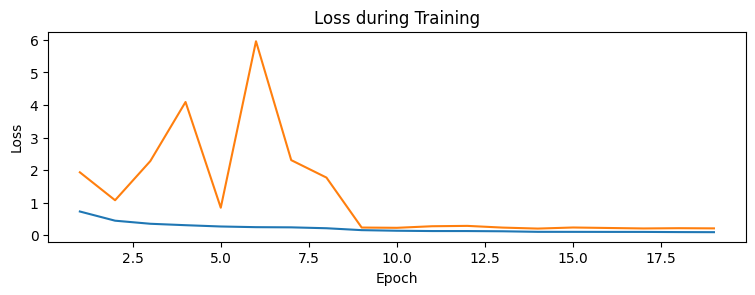

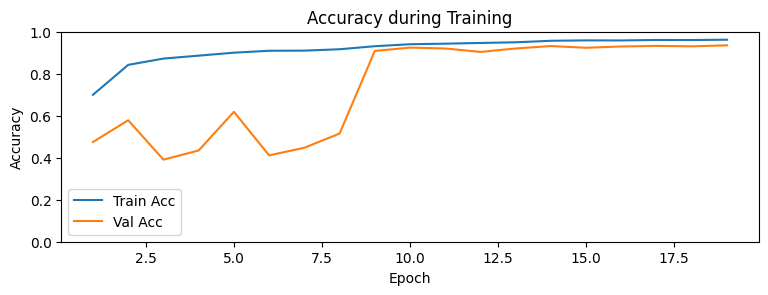

In [36]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
train_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

# Plot loss
plt.figure(figsize=(9, 6))
plt.subplot(2, 1, 1)
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Train Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Val Loss')
plt.title('Loss during Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.figure(figsize=(9,6))
plt.subplot(2, 1, 2)
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Train Acc')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Val Acc')
plt.title('Accuracy during Training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.legend()

CLASSIFICATION REPORT FOR VALIDATION SET

In [37]:
from sklearn.metrics import classification_report, balanced_accuracy_score, roc_auc_score
import numpy as np

# Predict probabilities for the validation set
y_val_pred_probs = model.predict(X_val)

# Convert probabilities to class labels
y_val_pred = np.argmax(y_val_pred_probs, axis=1)
y_val_true = np.argmax(Y_val, axis=1)  


print("Classification Report:")
print(classification_report(y_val_true, y_val_pred, target_names=['0','1','2','3']))

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       696
           1       0.96      0.87      0.91       549
           2       0.96      0.98      0.97       137
           3       0.99      0.96      0.98        84

    accuracy                           0.93      1466
   macro avg       0.95      0.94      0.95      1466
weighted avg       0.93      0.93      0.93      1466



In [38]:
from sklearn.metrics import balanced_accuracy_score

# Compute the balanced accuracy score
score = balanced_accuracy_score(y_val_true, y_val_pred)

print(f"Balanced Accuracy Score: {score:.2f}")


Balanced Accuracy Score: 0.94


In [39]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# Binarize the true labels for multi-class
y_true_binarized = label_binarize(y_val_true, classes=[0, 1, 2, 3])
y_scores = model.predict(X_val)
# Compute ROC AUC score (macro average)
roc_auc = roc_auc_score(y_true_binarized, y_scores, multi_class="ovr", average="macro")

print(f"ROC AUC Score (Macro): {roc_auc:.2f}")


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
ROC AUC Score (Macro): 0.99


TEST DATA

In [42]:
y_test_pred = model.predict(test_data)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [44]:
print(y_test_pred)

[[9.9999541e-01 4.5255319e-06 2.4490094e-09 6.4538273e-14]
 [9.5384610e-01 1.0236236e-02 3.5732962e-02 1.8457136e-04]
 [7.9600097e-05 9.9992031e-01 9.0612554e-13 1.8315711e-10]
 ...
 [1.8655526e-09 1.0000000e+00 2.5946445e-22 5.6384326e-16]
 [5.5599820e-08 9.9999988e-01 1.4631937e-10 8.9778204e-08]
 [9.8886430e-01 1.1135374e-02 3.6624212e-07 7.7082181e-09]]


In [46]:
predicted_labels = np.argmax(y_test_pred, axis=1)
print(predicted_labels.shape)

(779,)


In [47]:
file_names = [f"test_{i+1}.npy" for i in range(y_test_pred.shape[0])]

In [48]:
df = pd.DataFrame({'file_name': file_names, 'label': predicted_labels})
df.to_csv('test_outputs.csv', index=False)